In [42]:
import requests
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import MeanSquaredError
from datetime import datetime, timedelta

In [43]:
df = pd.read_csv('kolkata_aqi.csv')
df.head()

,date,co,no,no2,o3,so2,pm2_5,pm10,nh3
0,25-11-20 1:00,2616.88,2.18,70.60,13.59,38.62,364.61,411.73,28.63
1,25-11-20 2:00,3631.59,23.25,89.11,0.33,54.36,420.96,486.21,41.04
2,25-11-20 3:00,4539.49,52.75,100.08,1.11,68.67,463.68,541.95,49.14
3,25-11-20 4:00,4539.49,50.96,111.04,6.44,78.20,454.81,534.00,48.13
4,25-11-20 5:00,4379.27,42.92,117.90,17.17,87.74,448.14,529.19,46.61


In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18776 entries, 0 to 18775
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    18776 non-null  object 
 1   co      18776 non-null  float64
 2   no      18776 non-null  float64
 3   no2     18776 non-null  float64
 4   o3      18776 non-null  float64
 5   so2     18776 non-null  float64
 6   pm2_5   18776 non-null  float64
 7   pm10    18776 non-null  float64
 8   nh3     18776 non-null  float64
dtypes: float64(8), object(1)
memory usage: 1.3+ MB


In [45]:
df.columns

Index(['date', 'co', 'no', 'no2', 'o3', 'so2', 'pm2_5', 'pm10', 'nh3'], dtype='object')

In [46]:
df.describe()

,co,no,no2,o3,so2,pm2_5,pm10,nh3
count,18776.000000,18776.000000,18776.000000,18776.000000,18776.000000,18776.000000,18776.000000,18776.000000
mean,2929.228628,33.660702,66.221299,60.346239,66.693633,238.130309,300.092966,25.109815
std,2854.523506,62.127118,48.527492,80.464932,49.439191,226.533625,267.165827,26.402108
min,260.350000,0.000000,4.280000,0.000000,5.250000,11.830000,15.070000,0.000000
25%,1068.120000,0.680000,33.930000,0.340000,34.810000,84.440000,118.797500,9.630000
50%,1842.500000,5.250000,54.150000,27.180000,52.930000,157.445000,209.705000,17.480000
75%,3685.000000,35.760000,83.630000,92.980000,82.020000,313.000000,387.965000,30.400000
max,21148.680000,500.680000,460.620000,801.090000,579.830000,1708.090000,1969.930000,287.770000


In [47]:
df.isna().sum()

date     0
co       0
no       0
no2      0
o3       0
so2      0
pm2_5    0
pm10     0
nh3      0
dtype: int64

In [48]:
df.duplicated().sum()

0

In [49]:
df['date'] = pd.to_datetime(df['date'], format='%d-%m-%y %H:%M')

In [50]:
df.head()

,date,co,no,no2,o3,so2,pm2_5,pm10,nh3
0,2020-11-25 01:00:00,2616.88,2.18,70.60,13.59,38.62,364.61,411.73,28.63
1,2020-11-25 02:00:00,3631.59,23.25,89.11,0.33,54.36,420.96,486.21,41.04
2,2020-11-25 03:00:00,4539.49,52.75,100.08,1.11,68.67,463.68,541.95,49.14
3,2020-11-25 04:00:00,4539.49,50.96,111.04,6.44,78.20,454.81,534.00,48.13
4,2020-11-25 05:00:00,4379.27,42.92,117.90,17.17,87.74,448.14,529.19,46.61


In [51]:
df.set_index('date', inplace=True)
df.sort_index(inplace=True)

In [52]:
df.head()

,co,no,no2,o3,so2,pm2_5,pm10,nh3
date,,,,,,,,
2020-11-25 01:00:00,2616.88,2.18,70.60,13.59,38.62,364.61,411.73,28.63
2020-11-25 02:00:00,3631.59,23.25,89.11,0.33,54.36,420.96,486.21,41.04
2020-11-25 03:00:00,4539.49,52.75,100.08,1.11,68.67,463.68,541.95,49.14
2020-11-25 04:00:00,4539.49,50.96,111.04,6.44,78.20,454.81,534.00,48.13
2020-11-25 05:00:00,4379.27,42.92,117.90,17.17,87.74,448.14,529.19,46.61


In [53]:
print('Dataset Shape',df.shape)

Dataset Shape (18776, 8)


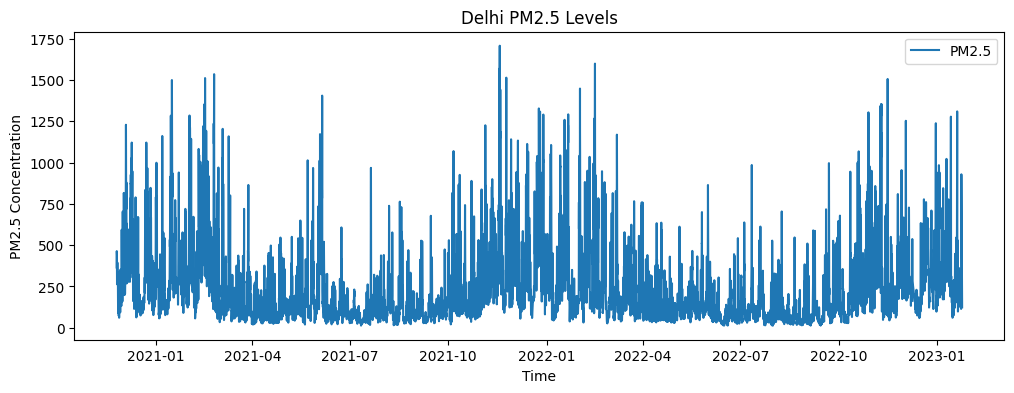

In [54]:
plt.figure(figsize=(12,4))
plt.plot(df['pm2_5'], label='PM2.5')
plt.title("Delhi PM2.5 Levels")
plt.xlabel("Time")
plt.ylabel("PM2.5 Concentration")
plt.legend()
plt.show()

In [55]:
features = ['co', 'no', 'no2', 'o3', 'so2', 'pm10', 'nh3']
target = 'pm2_5'

In [56]:
data = df[features + [target]].dropna()

In [57]:
X_features = data[features]
y_target = data[target]

In [58]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

In [59]:
#scaled_data = np.hstack((scaled_features, y_target.values.reshape(-1, 1)))

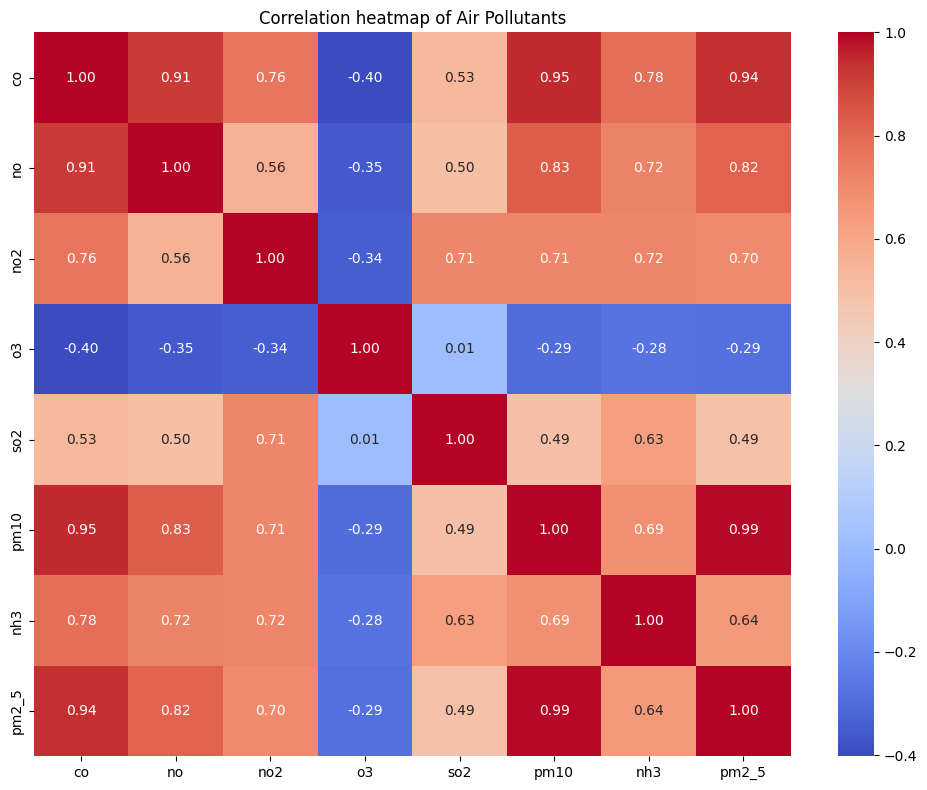

In [60]:
#Correlation heatmap
plt.figure(figsize=(10,8))
sns.heatmap(data.corr(),annot=True,cmap='coolwarm',fmt=".2f")
plt.title('Correlation heatmap of Air Pollutants')
plt.tight_layout()
plt.show()

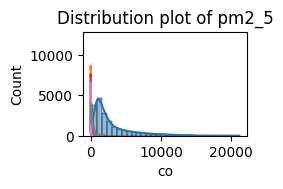

In [61]:
#Distribution Plot
for i,col in enumerate(data.columns,1):
  plt.subplot(3,3,1)
  sns.histplot(data[col],kde=True,bins=30)
  plt.title(f'Distribution plot of {col}')

plt.tight_layout()
plt.show()

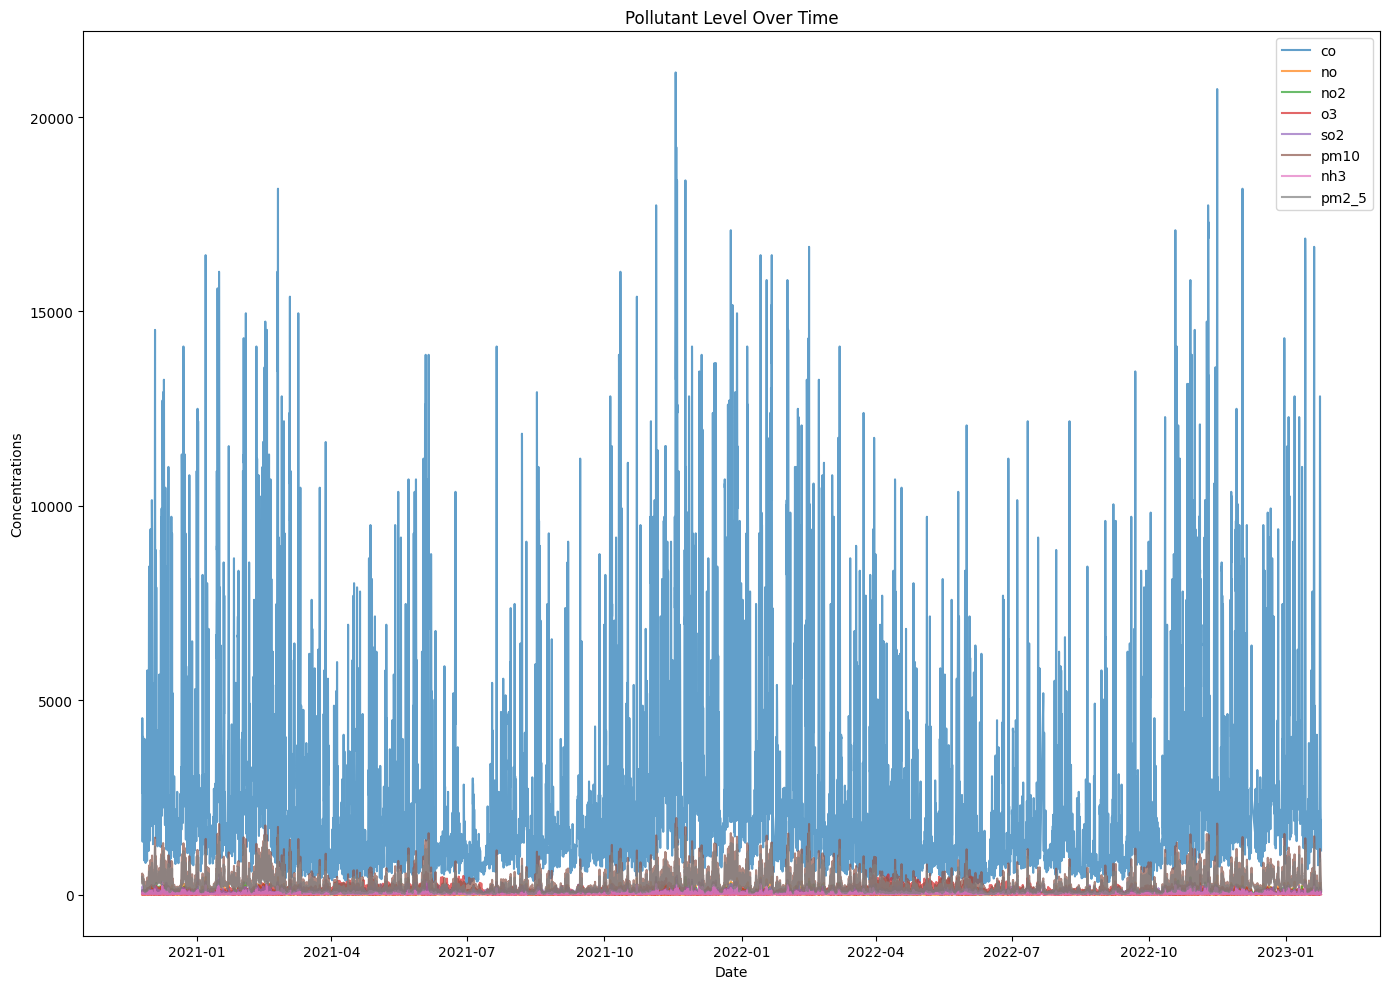

In [62]:
#Time Series Plot of all pollutants
plt.figure(figsize=(14,10))
for col in data.columns:
  plt.plot(data.index,data[col],label=col,alpha=0.7)
plt.title('Pollutant Level Over Time')
plt.xlabel('Date')
plt.ylabel('Concentrations')
plt.legend()
plt.tight_layout()
plt.show()

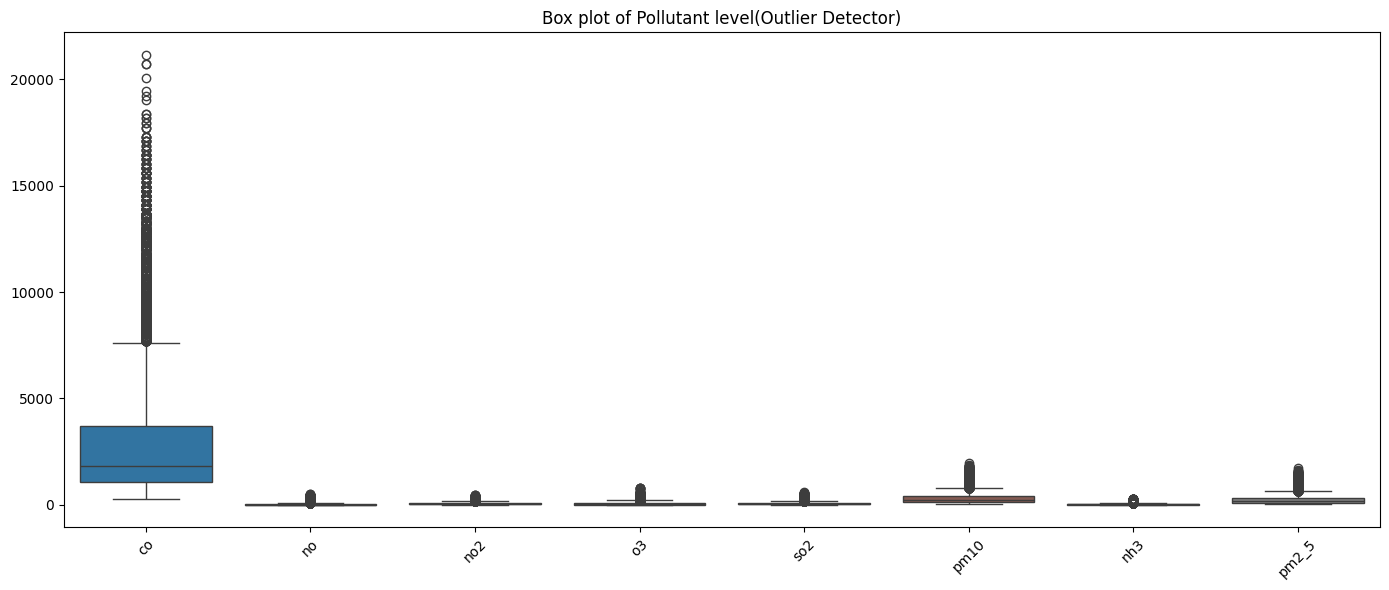

In [63]:
plt.figure(figsize=(14,6))
sns.boxplot(data=data)
plt.title('Box plot of Pollutant level(Outlier Detector)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [64]:
def create_sequences(data,look_back=24,forecast_horizon=3):
  X,y=[],[]
  for i in range(look_back,len(data)-forecast_horizon+1):
    X.append(data[i-look_back:i,:-1])
    y.append(data[i:i+forecast_horizon,-1])

  return np.array(X),np.array(y)

In [65]:
look_back=24
forcast_horizon=3
X,y=create_sequences(scaled_data,look_back,forcast_horizon)

In [66]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,shuffle=False)
print(X_train.shape)
print(X_test.shape)

(15000, 24, 7)
(3750, 24, 7)


In [67]:
#LSTM Model
lstm_model=Sequential([
    LSTM(64,input_shape=(X_train.shape[1],X_train.shape[2])),
    Dense(forcast_horizon)
])
lstm_model.compile(optimizer='adam', loss=MeanSquaredError())
lstm_model.fit(X_train,y_train,epochs=10,batch_size=64,validation_split=0.2)

c:\Users\My\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 0.0136 - val_loss: 0.0022
Epoch 2/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0051 - val_loss: 0.0020
Epoch 3/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0038 - val_loss: 0.0015
Epoch 4/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0033 - val_loss: 0.0016
Epoch 5/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0032 - val_loss: 0.0017
Epoch 6/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0029 - val_loss: 0.0018
Epoch 7/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0029 - val_loss: 0.0014
Epoch 8/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0028 - val_loss: 0.0014
Epoch 9/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0026 - val_loss: 0.0015
Epoch 10/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0026 - val_loss: 0.0015


In [68]:
lstm_model.save('lstm_model.h5')

In [69]:
#GRU Model
gru_model=Sequential([
    GRU(64,input_shape=(X_train.shape[1],X_train.shape[2])),
    Dense(forcast_horizon)
])
gru_model.compile(optimizer='adam', loss=MeanSquaredError())
gru_model.fit(X_train,y_train,epochs=10,batch_size=64,validation_split=0.2)

Epoch 1/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - loss: 0.0105 - val_loss: 0.0018
Epoch 2/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.0039 - val_loss: 0.0017
Epoch 3/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0035 - val_loss: 0.0020
Epoch 4/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0032 - val_loss: 0.0017
Epoch 5/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 0.0031 - val_loss: 0.0019
Epoch 6/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0030 - val_loss: 0.0019
Epoch 7/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 0.0028 - val_loss: 0.0018
Epoch 8/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 0.0027 - val_loss: 0.0016
Epoch 9/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0025 - val_loss: 0.0016
Epoch 10/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0024 - val_loss: 0.0015


In [70]:
gru_model.save('gru_model.h5')

In [71]:
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [72]:
lstm_preds = lstm_model.predict(X_test)
gru_preds = gru_model.predict(X_test)

118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step


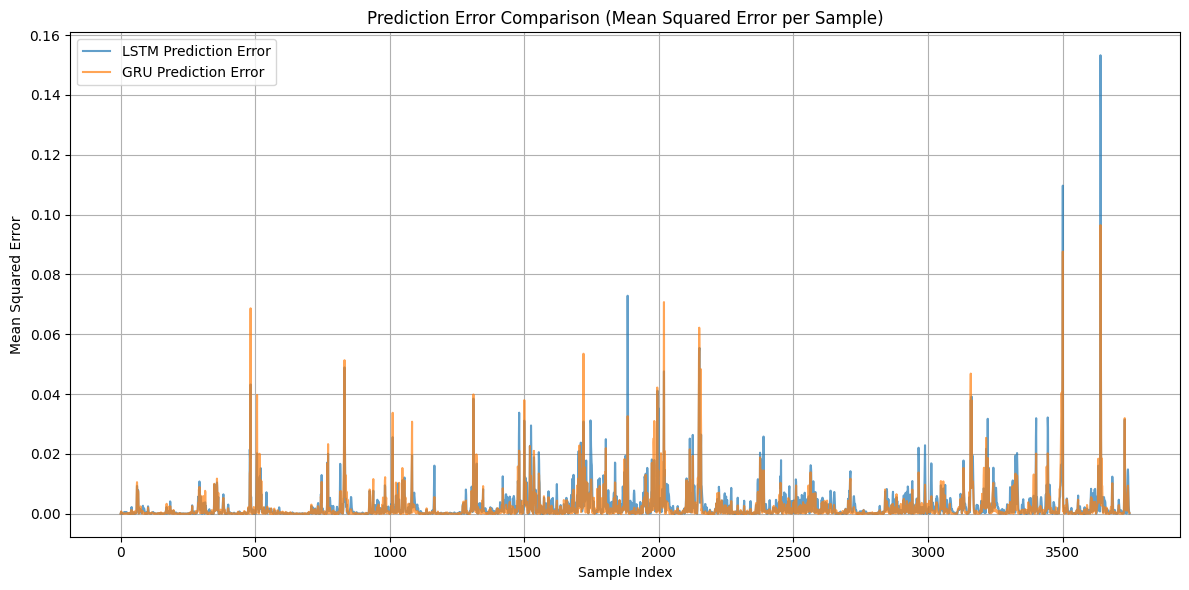

LSTM Mean Absolute Error: 0.04
LSTM Root Mean Squared Error: 0.05
GRU Mean Absolute Error: 0.03
GRU Root Mean Squared Error: 0.05


In [73]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
lstm_errors = np.mean((y_test - lstm_preds)**2, axis=1)
gru_errors = np.mean((y_test - gru_preds)**2, axis=1)

plt.figure(figsize=(12, 6))
plt.plot(lstm_errors, label='LSTM Prediction Error', alpha=0.7)
plt.plot(gru_errors, label='GRU Prediction Error', alpha=0.7)
plt.title("Prediction Error Comparison (Mean Squared Error per Sample)")
plt.xlabel("Sample Index")
plt.ylabel("Mean Squared Error")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"LSTM Mean Absolute Error: {mean_absolute_error(y_test, lstm_preds):.2f}")
print(f"LSTM Root Mean Squared Error: {np.sqrt(mean_squared_error(y_test, lstm_preds)):.2f}")
print(f"GRU Mean Absolute Error: {mean_absolute_error(y_test, gru_preds):.2f}")
print(f"GRU Root Mean Squared Error: {np.sqrt(mean_squared_error(y_test, gru_preds)):.2f}")


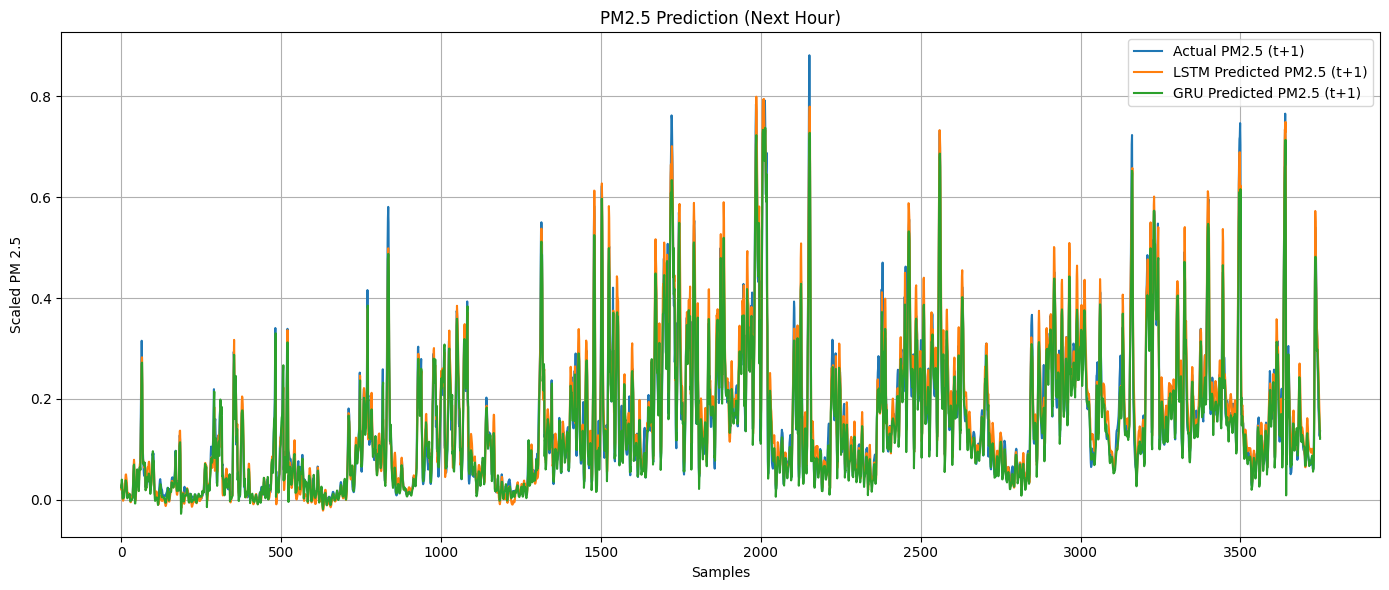

In [74]:
plt.figure(figsize=(14,6))
plt.plot(y_test[:,0],label='Actual PM2.5 (t+1)')
plt.plot(lstm_preds[:,0],label='LSTM Predicted PM2.5 (t+1)')
plt.plot(gru_preds[:,0],label='GRU Predicted PM2.5 (t+1)')
plt.title('PM2.5 Prediction (Next Hour)')
plt.xlabel('Samples')
plt.ylabel('Scaled PM 2.5')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

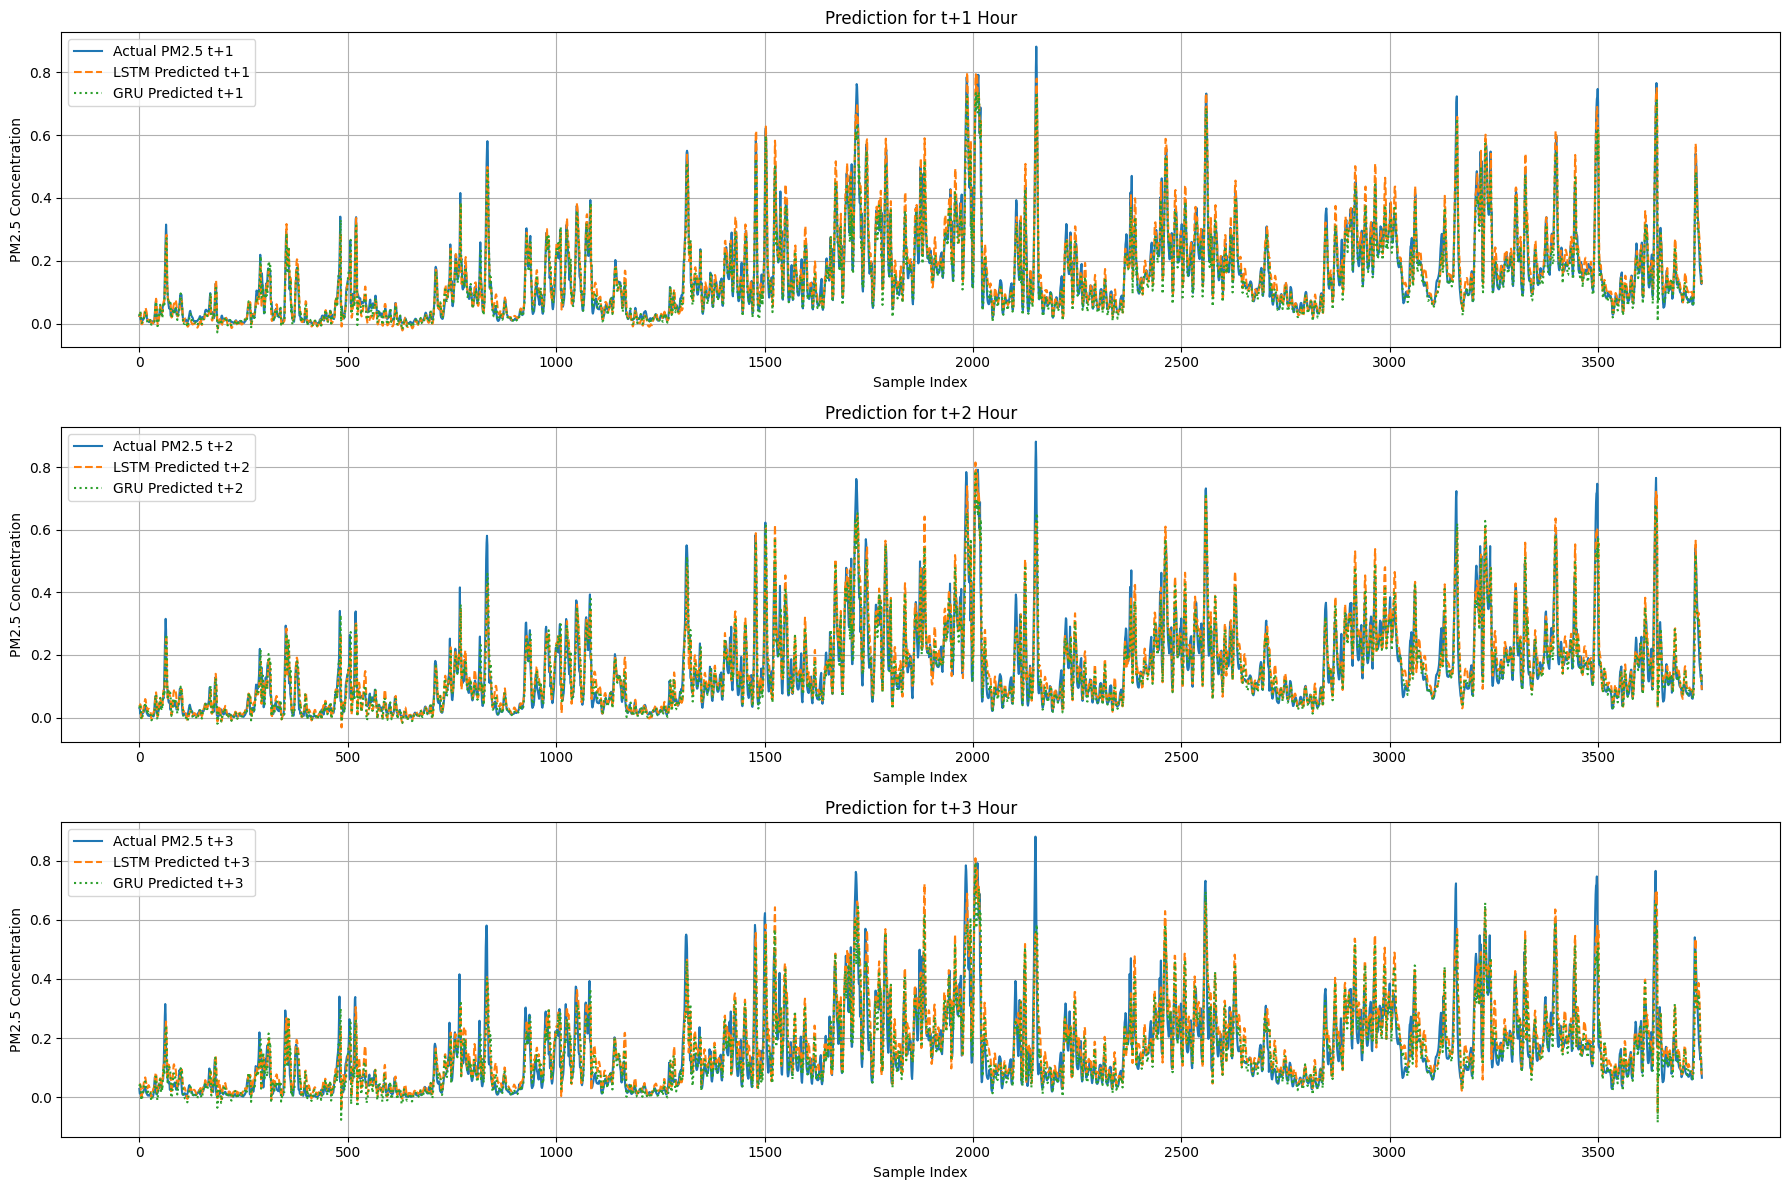

In [75]:
time_steps = [1, 2, 3]
plt.figure(figsize=(18, 12))
for i, t in enumerate(time_steps):
    plt.subplot(3, 1, i + 1)
    plt.plot(y_test[:, i], label=f'Actual PM2.5 t+{t}')
    plt.plot(lstm_preds[:, i], label=f'LSTM Predicted t+{t}', linestyle='--')
    plt.plot(gru_preds[:, i], label=f'GRU Predicted t+{t}', linestyle=':')
    plt.title(f"Prediction for t+{t} Hour")
    plt.xlabel("Sample Index")
    plt.ylabel("PM2.5 Concentration")
    plt.legend()
    plt.grid(True)
plt.tight_layout()
plt.show()

In [76]:
results_df = pd.DataFrame({
    'Actual_t+1': y_test[:, 0],
    'Actual_t+2': y_test[:, 1],
    'Actual_t+3': y_test[:, 2],
    'LSTM_Pred_t+1': lstm_preds[:, 0],
    'LSTM_Pred_t+2': lstm_preds[:, 1],
    'LSTM_Pred_t+3': lstm_preds[:, 2],
    'GRU_Pred_t+1': gru_preds[:, 0],
    'GRU_Pred_t+2': gru_preds[:, 1],
    'GRU_Pred_t+3': gru_preds[:, 2],
})
results_df.head()
#results_df.to_csv("pm25_predictions.csv", index=False)

,Actual_t+1,Actual_t+2,Actual_t+3,LSTM_Pred_t+1,LSTM_Pred_t+2,LSTM_Pred_t+3,GRU_Pred_t+1,GRU_Pred_t+2,GRU_Pred_t+3
0,0.024200,0.030078,0.028174,0.020629,0.035367,0.041626,0.024637,0.031570,0.037863
1,0.030078,0.028174,0.012475,0.025685,0.038266,0.042169,0.031563,0.036611,0.042355
2,0.028174,0.012475,0.011973,0.033517,0.042498,0.044326,0.039992,0.043115,0.047610
3,0.012475,0.011973,0.016242,0.032803,0.037210,0.036989,0.031696,0.035920,0.032894
4,0.011973,0.016242,0.016613,0.010710,0.010191,0.009422,0.003474,0.004702,-0.006351


In [77]:
from tensorflow.keras.layers import LayerNormalization, MultiHeadAttention, Dropout, Input, GlobalAveragePooling1D, Dense, Layer, Add
from tensorflow.keras.models import Model, Sequential

class TransformerBlock(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = Sequential([
            Dense(ff_dim, activation="relu"),
            Dense(embed_dim),
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training=None):  # <- fix here
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

# Hyperparameters
embed_dim = 64
num_heads = 4
ff_dim = 128
dropout_rate = 0.1

# Input shape (look_back, num_features)
input_shape = (X_train.shape[1], X_train.shape[2])  # e.g., (24, 7)
inputs = Input(shape=input_shape)

# PROJECT input to embed_dim
x = Dense(embed_dim)(inputs)

# Transformer block
x = TransformerBlock(embed_dim, num_heads, ff_dim, dropout_rate)(x)

# Output layers
x = GlobalAveragePooling1D()(x)
x = Dropout(0.1)(x)
x = Dense(64, activation='relu')(x)
outputs = Dense(forcast_horizon)(x)  # <- your regression output

# Compile model
transformer_model = Model(inputs=inputs, outputs=outputs)
transformer_model.compile(optimizer='adam', loss=MeanSquaredError())
transformer_model.summary()

# Fit model
transformer_model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2)

# Save
transformer_model.save('transformer_model.h5')

# Predict
transformer_preds = transformer_model.predict(X_test)


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 24, 7)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 24, 64)         │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_1             │ (None, 24, 64)         │        83,200 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 88,067 (344.01 KB)

 Trainable params: 88,067 (344.01 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 19s 54ms/step - loss: 0.0964 - val_loss: 0.0049
Epoch 2/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 11s 58ms/step - loss: 0.0152 - val_loss: 0.0037
Epoch 3/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - loss: 0.0124 - val_loss: 0.0045
Epoch 4/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 11s 57ms/step - loss: 0.0116 - val_loss: 0.0031
Epoch 5/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 11s 56ms/step - loss: 0.0110 - val_loss: 0.0033
Epoch 6/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - loss: 0.0107 - val_loss: 0.0040
Epoch 7/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - loss: 0.0108 - val_loss: 0.0032
Epoch 8/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - loss: 0.0103 - val_loss: 0.0034
Epoch 9/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 12s 64ms/step - loss: 0.0101 - val_loss: 0.0032
Epoch 10/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 18s 48ms/step - loss: 0.0099 - val_loss: 0.0032


118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step


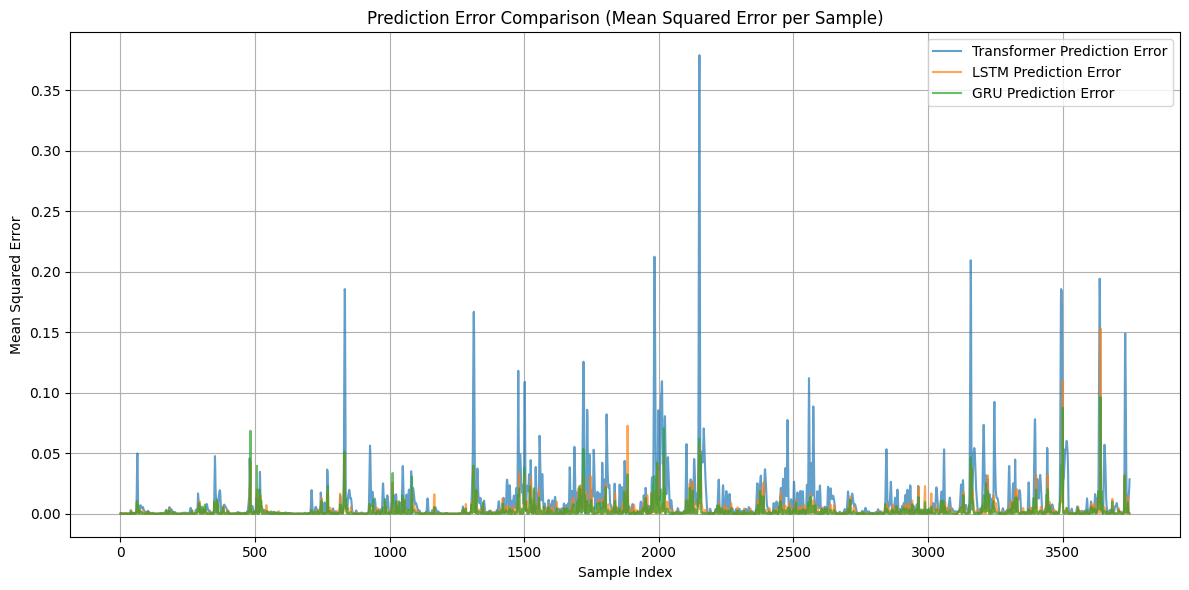

Transformer MAE: 0.07
Transformer RMSE: 0.10


In [78]:
transformer_errors = np.mean((y_test - transformer_preds)**2, axis=1)
plt.figure(figsize=(12, 6))
plt.plot(transformer_errors, label='Transformer Prediction Error', alpha=0.7)
plt.plot(lstm_errors, label='LSTM Prediction Error', alpha=0.7)
plt.plot(gru_errors, label='GRU Prediction Error', alpha=0.7)
plt.title("Prediction Error Comparison (Mean Squared Error per Sample)")
plt.xlabel("Sample Index")
plt.ylabel("Mean Squared Error")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"Transformer MAE: {mean_absolute_error(y_test, transformer_preds):.2f}")
print(f"Transformer RMSE: {np.sqrt(mean_squared_error(y_test, transformer_preds)):.2f}")

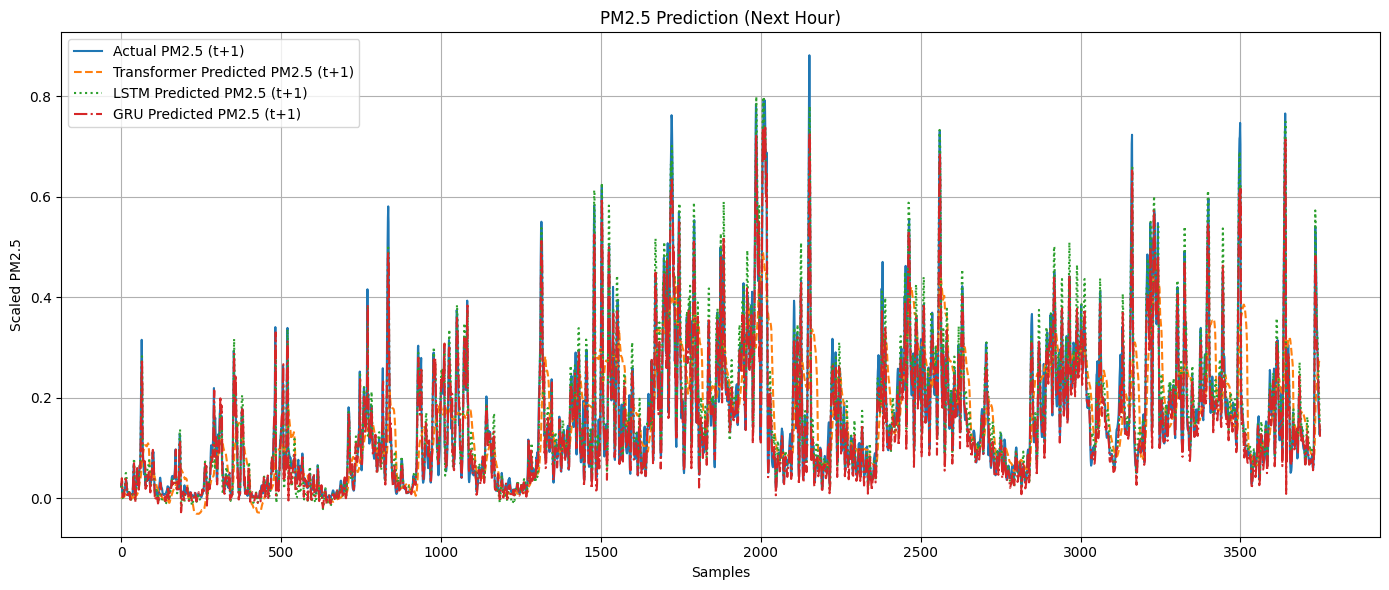

In [79]:
plt.figure(figsize=(14,6))
plt.plot(y_test[:,0],label='Actual PM2.5 (t+1)')
plt.plot(transformer_preds[:,0],label='Transformer Predicted PM2.5 (t+1)', linestyle='--')
plt.plot(lstm_preds[:,0],label='LSTM Predicted PM2.5 (t+1)', linestyle=':')
plt.plot(gru_preds[:,0],label='GRU Predicted PM2.5 (t+1)', linestyle='-.')
plt.title('PM2.5 Prediction (Next Hour)')
plt.xlabel('Samples')
plt.ylabel('Scaled PM2.5')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [80]:
results_df['Transformer_Pred_t+1'] = transformer_preds[:, 0]
results_df['Transformer_Pred_t+2'] = transformer_preds[:, 1]
results_df['Transformer_Pred_t+3'] = transformer_preds[:, 2]
results_df.head()
# results_df.to_csv("pm25_predictions.csv", index=False)

,Actual_t+1,Actual_t+2,Actual_t+3,LSTM_Pred_t+1,LSTM_Pred_t+2,LSTM_Pred_t+3,GRU_Pred_t+1,GRU_Pred_t+2,GRU_Pred_t+3,Transformer_Pred_t+1,Transformer_Pred_t+2,Transformer_Pred_t+3
0,0.024200,0.030078,0.028174,0.020629,0.035367,0.041626,0.024637,0.031570,0.037863,-0.000066,0.021002,0.007586
1,0.030078,0.028174,0.012475,0.025685,0.038266,0.042169,0.031563,0.036611,0.042355,0.000514,0.021611,0.008208
2,0.028174,0.012475,0.011973,0.033517,0.042498,0.044326,0.039992,0.043115,0.047610,0.001093,0.022253,0.008863
3,0.012475,0.011973,0.016242,0.032803,0.037210,0.036989,0.031696,0.035920,0.032894,0.001861,0.023194,0.009762
4,0.011973,0.016242,0.016613,0.010710,0.010191,0.009422,0.003474,0.004702,-0.006351,0.002129,0.023483,0.010085


In [81]:
#Confidence Intervals
import scipy.stats as stats

def get_confidence_interval(preds, y_true, confidence=0.95):
    residuals = y_true - preds
    std_err = np.std(residuals, axis=0)
    n = preds.shape[0]
    margin_error = stats.t.ppf((1 + confidence) / 2., n - 1) * (std_err / np.sqrt(n))
    lower_bound = preds - margin_error
    upper_bound = preds + margin_error
    return lower_bound, upper_bound

# LSTM
lstm_lower, lstm_upper = get_confidence_interval(lstm_preds, y_test)

# GRU
gru_lower, gru_upper = get_confidence_interval(gru_preds, y_test)

# Transformer
transformer_preds = transformer_model.predict(X_test)
transformer_lower, transformer_upper = get_confidence_interval(transformer_preds, y_test)

118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


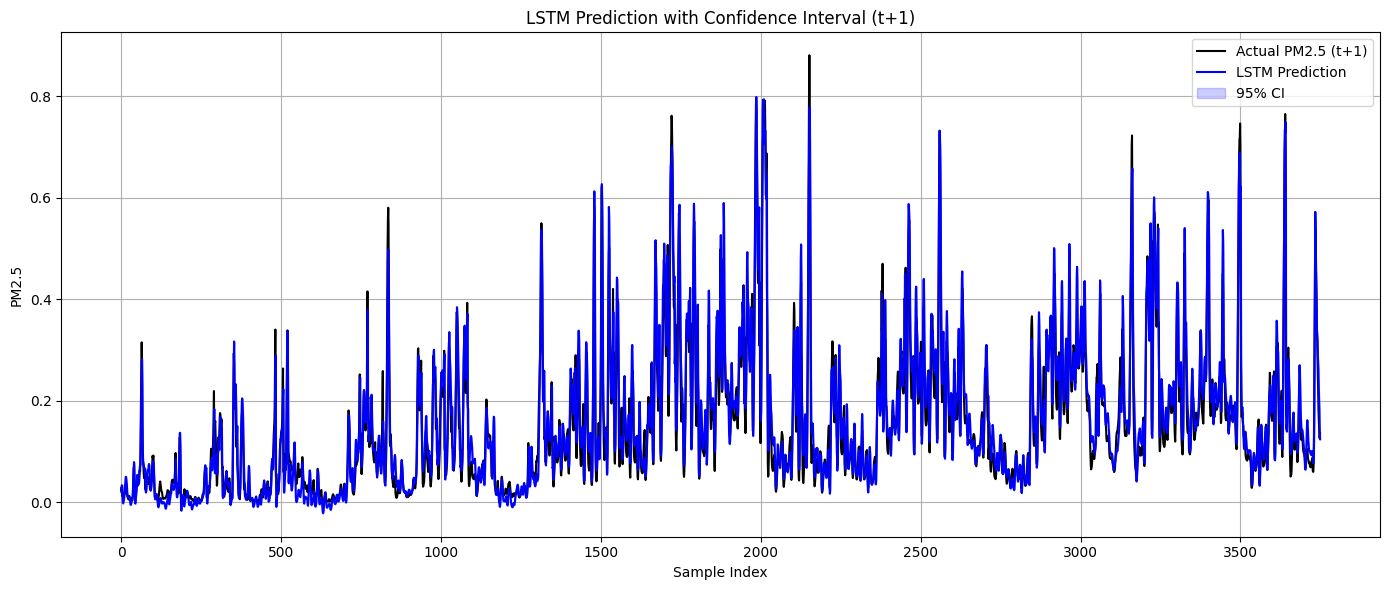

In [82]:
plt.figure(figsize=(14,6))
plt.plot(y_test[:,0], label='Actual PM2.5 (t+1)', color='black')
plt.plot(lstm_preds[:,0], label='LSTM Prediction', color='blue')
plt.fill_between(range(len(lstm_preds)), lstm_lower[:,0], lstm_upper[:,0], color='blue', alpha=0.2, label='95% CI')
plt.title('LSTM Prediction with Confidence Interval (t+1)')
plt.xlabel('Sample Index')
plt.ylabel('PM2.5')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()